In [1]:
# Imports

from dataExtraction import extract
from IPython.display import clear_output
from pprint import pprint

import pandas as pd
from transformers import pipeline
import re
import statistics
import os
import seaborn as sns
import matplotlib.pyplot as plt

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Import Data

In [7]:
df = pd.read_csv('data.csv')
df.head(10)

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,['As the data driven mindset is more and more ...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","[""Location: Dubai, UAE (We provide visa sponso...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,['Halen we in Nederland de klimaatdoelen op he...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,['As a Data Scientist in the Research & Invest...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,['Improving the working lives of millions of p...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...
5,Data Scientist,Adyen,Amsterdam,Nationale Vacaturebank,Functieomschrijving Data Analytics Amsterdam T...,"[""Functieomschrijving\n\nData Analytics Amster...","{'posted_at': '17 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...
6,Data Scientist bij Transavia,Transavia,Schiphol,Vacatures - Transa,Wij zoeken jou als Data Scientist Voor ons Str...,['Wij zoeken jou als Data Scientist\n\nVoor on...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBiaWogVH...
7,Data Science Lead - Amsterdam,Bynder,Amsterdam,Careers At Bynder,Bynder goes far beyond managing digital assets...,['Bynder goes far beyond managing digital asse...,"{'posted_at': '2 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgTGVhZCAtIE...
8,"LEAD DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Rotterdam,LinkedIn,Employment type: Full-time & Permanent Reports...,"[""Employment type: Full-time & Permanent\n\nRe...","{'posted_at': '1 day ago', 'schedule_type': 'F...",eyJqb2JfdGl0bGUiOiJMRUFEIERBVEEgU0NJRU5USVNUIC...
9,Data Science and Artificial Intelligence Fello...,Wageningen University & Research,Wageningen,AcademicTransfer,Are you a computer scientist with a PhD degree...,['Are you a computer scientist with a PhD degr...,{'posted_at': '2 days ago'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgYW5kIEFydG...


In [8]:
df['job_highlights'] = df['job_highlights'].replace(r'\n\n|\n•|\n|\\n|\\n•|•', '', regex=True)  # Remove new line char
df['job_highlights'] = df['job_highlights'].str.slice(2, -2)  # Remove [] and additional "" marks

## Salary Extraction
Take salary information out of the text fields and put them into a separate column.

In [9]:
def extract_salary():
    qa_model = pipeline("question-answering", 
                    model='distilbert-base-cased-distilled-squad') # Define the model 
    question = "What is the salary or salary range for the job?"  # Define the quesiton to be answered
    df['salary'] = df.apply(lambda x: "Not available" if qa_model(question=question, 
                                                                           context=(x['job_highlights'] + 
                                                                                    x['title'] + 
                                                                                    x['description']))['score'] < 0.3
                                                                else qa_model(question=question, 
                                                                              context=(x['job_highlights'] + 
                                                                                       x['title'] + 
                                                                                       x['description']))['answer'], axis=1)
    return df
    
df = extract_salary()

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [5]:
df['salary'] = df['salary'].str.replace(',', '', regex=True)  # Replace comma point in numerical values
df['salary'] = df['salary'].str.replace('.', '', regex=True)  # Replace dot point in numerical values

KeyError: 'salary'

In [35]:
def find_specified_salary(x):    
    values = re.findall(r'\d+', str(x))  # Identify numerical values
    salary = 'Not available'
    salary_range = 'Not available'
    if len(values) == 1:  # Single numerical value, not a range
        salary = int(values[0]) 
        
    elif len(values) == 2:  # Two numerical values indicate a range
        min_salary = int(values[0])  # Min of salary range
        max_salary = int(values[1])  # Max of salary range
        salary = statistics.median([min_salary, max_salary])  # Calculate range median
        salary_range = str(min_salary) + "-" + str(max_salary)  # Format range
        
    return pd.Series([salary, salary_range])


df[['salary', 'salary_range']] = df['salary'].apply(find_specified_salary)

### Handle different currencies

In [36]:
currency_mapping = {'AUD': 'AUD', 
                    'EUR': 'EUR', 
                    'JPY': 'JPY', 
                    'CHF': 'CHF', 
                    'USD': 'USD',
                    'GBP': 'GBP',
                    'dollar': 'USD', 
                    'euro': 'EUR', 
                    'pound': 'GBP', 
                    'default': 'EUR'}

currency_indicators = ['AUD', 'GBP', 'EUR', 'JPY', 'CHF', 'USD', 'dollar', 'euro', 'pound'] # 6 dominant country codes    


def identify_currencies():
    regex_pattern = '|'.join([f'{key_word}' for key_word in currency_indicators])  # Create regex pattern
    search_space = df['description'] + df['title'] + df['job_highlights']  # Concatenate key strings into a single search space
    currencies = search_space.map(lambda x:currency_mapping['default'] if len(re.findall(regex_pattern, x)) == 0
                             else currency_mapping[re.findall(regex_pattern, x)[0]])  # Perform regex search in search space
    df['currency'] = currencies  # Assign determined currency
    return df
    
    
df = identify_currencies()

In [37]:
df.head(5)

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,currency
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,EUR
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,Not available,USD
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,Not available,EUR
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,Not available,EUR
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,47500-90000,EUR


In [38]:
df.to_csv('data_salaries.csv')

## Country Extraction

In [39]:
country_mapping = {
    'UK': 'GBR',
    'United Kingdom': 'GBR',
    'France': 'FRA',
    'Italy': 'ITA',
    'Spain': 'ESP',
    'Belgium': 'BEL',
    'Netherlands': 'NDL',
    'Nederland': 'NDL',
    'Dutch': 'NDL',
    'Dubai': 'UAE',
    'UAE': 'UAE',
    'Germany': 'DEU',
    'Deutschland': 'DEU',
    'Denmark': 'DNK',
    'Austria': 'AUT',
    'Czech': 'CZE',
    'default': 'Not available'
}

country_names = ['UK', 'United Kingdom', 'France', 'Italy', 'Spain', 
                 'Belgium', 'Netherlands', 'Nederland', 'Dutch', 'Dubai', 'UAE',
                'Germany', 'Deutschland', 'Denmark', 'Austria', 'Czech']


def identify_countries(df: pd.DataFrame):
    regex_pattern = '|'.join([f'{key_word}' for key_word in country_names])  # Create regex pattern
    search_space = df['title'] + df['description'] + df['job_highlights']
    countries = search_space.map(lambda x: country_mapping['default'] if len(re.findall(regex_pattern, x)) == 0
                                else country_mapping[re.findall(regex_pattern, x)[0]])
    df['country'] = countries
    return df


df = identify_countries(df)

In [40]:
df.head(5)

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,currency,country
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,EUR,NDL
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,Not available,USD,UAE
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,Not available,EUR,NDL
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,Not available,EUR,Not available
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,47500-90000,EUR,NDL


In [41]:
df.to_csv('data_country.csv')

## Skills Extraction

In [42]:
# Add empty columns
skills_list = []
with open("notes_and_prototypes/skills_list.txt") as file:
    while (line := file.readline().rstrip()):
        if line == "R":
            skills_list.append(" R ")
        else:
            skills_list.append(line)


# Replace blank spaces with underscores for dataframe columns
columns_list = []
for element in skills_list:
    columns_list.append(element.replace(" ", "_"))

for element in columns_list:
    df[element] = 0

['Apache Spark', 'Apache Flink', 'Apache Beam', 'Artificial intelligence', 'Big data', 'Bokeh', 'Business intelligence', 'C++', 'C#', 'Communication', 'Computer science', 'Confidence intervals', 'Correlation', 'Creativity', 'Critical thinking', 'Dash', 'Dask', 'Data engineering', 'Data management', 'Data mining', 'Data modeling', 'Data visualization', 'Database', 'Deep learning', 'Descriptive statistics', 'Detail-oriented', 'Development', 'Dimensionality reduction', 'Django', 'Economics', 'ETL', 'Experimentation', 'Exploratory data analysis', 'FastAPI', 'Feature engineering', 'Flask', 'Forecasting', 'Git', 'Hadoop', 'Hypothesis testing', 'Information retrieval', 'Java', 'JavaScript', 'Kafka', 'Keras', 'Leadership', 'Linear algebra', 'Machine learning', 'Management', 'MapReduce', 'Mathematics', 'Matlab', 'Matplotlib', 'Metrics', 'Modeling', 'Natural language processing', 'Neural networks', 'NoSQL', 'Numpy', 'Object-oriented programming', 'Optimization', 'Pandas', 'Pattern recognition', 

/tmp/ipykernel_6383/652572229.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[element] = 0
/tmp/ipykernel_6383/652572229.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[element] = 0
/tmp/ipykernel_6383/652572229.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[element] = 0


,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,Not available,...,0,0,0,0,0,0,0,0,0,0
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,47500-90000,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Find keywords and set columns accordingly

for i, row in df.iterrows():
    for keyword in skills_list:
        if keyword.lower() in df.at[i, "description"].lower():
            col = keyword.replace(" ", "_")
            df.at[i, col] = 1
# Print first results to check
df.head(10)

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,...,0,0,0,0,0,1,0,0,0,0
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,Not available,...,0,0,0,0,0,1,0,0,0,0
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,47500-90000,...,0,0,0,0,0,1,0,0,0,0
5,Data Scientist,Adyen,Amsterdam,Nationale Vacaturebank,Functieomschrijving Data Analytics Amsterdam T...,FunctieomschrijvingData Analytics AmsterdamThi...,"{'posted_at': '17 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,Not available,Not available,...,1,0,0,0,0,0,0,0,0,0
6,Data Scientist bij Transavia,Transavia,Schiphol,Vacatures - Transa,Wij zoeken jou als Data Scientist Voor ons Str...,Wij zoeken jou als Data ScientistVoor ons Stra...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBiaWogVH...,Not available,Not available,...,1,0,0,0,0,1,0,0,0,0
7,Data Science Lead - Amsterdam,Bynder,Amsterdam,Careers At Bynder,Bynder goes far beyond managing digital assets...,Bynder goes far beyond managing digital assets...,"{'posted_at': '2 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgTGVhZCAtIE...,Not available,Not available,...,0,0,0,0,0,1,0,0,0,0
8,"LEAD DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Rotterdam,LinkedIn,Employment type: Full-time & Permanent Reports...,Employment type: Full-time & PermanentReports ...,"{'posted_at': '1 day ago', 'schedule_type': 'F...",eyJqb2JfdGl0bGUiOiJMRUFEIERBVEEgU0NJRU5USVNUIC...,150000,Not available,...,0,0,0,0,0,1,0,0,0,0
9,Data Science and Artificial Intelligence Fello...,Wageningen University & Research,Wageningen,AcademicTransfer,Are you a computer scientist with a PhD degree...,Are you a computer scientist with a PhD degree...,{'posted_at': '2 days ago'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgYW5kIEFydG...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0


## Export Data Frame to new CSV
With the new csv, all necessary information is extracted and will be the new basis to work with.

In [44]:
df.to_csv('data_clean.csv')

## EDA

In [3]:
df = pd.read_csv('data_clean.csv')
df.head()

,Unnamed: 0,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
0,0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,...,0,0,0,0,0,1,0,0,0,0
1,1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,...,0,0,0,0,0,1,0,0,0,0
2,2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,...,0,0,0,0,0,0,0,0,0,0
3,3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,...,0,0,0,0,0,0,0,0,0,0
4,4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,...,0,0,0,0,0,1,0,0,0,0


NameError: name 'plt' is not defined

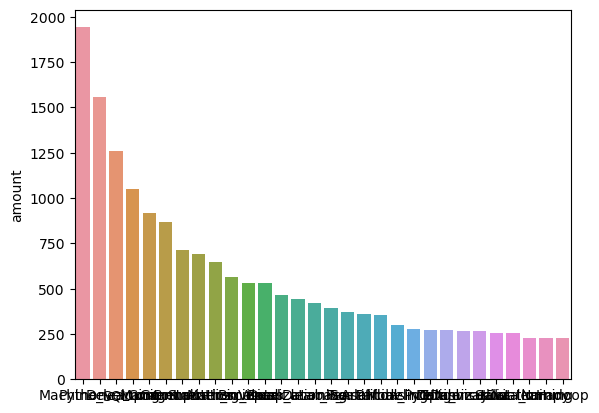

In [8]:
# Create bar-chart for top n skills

skills_df = df.iloc[:, 13:]
skills_df_sum = pd.DataFrame(skills_df.sum())
skills_df_sum.rename(columns={ skills_df_sum.columns[0]: "amount" }, inplace = True)
skills_df_sum = skills_df_sum.sort_values(by=["amount"], ascending=False)

# Set n
n = 30
skills_df_sum_top = skills_df_sum.head(n)
skills_df_sum_top

# Create chart'>' not supported between instances of 'numpy.ndarray' and 'str'
sns.barplot(data=skills_df_sum_top, x=skills_df_sum_top.index, y="amount")
plt.xticks(rotation=90)
plt.xlabel("Skills")
plt.ylabel("Total Amount of Occurrences in Job Offers")
plt.title("Most Important Skills in Data Science")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

### Salary

In [ ]:
available_salaries = df.salary[df.salary != 'Not available']
available_salaries.mean()

In [ ]:
available_salaries = available_salaries.astype(float)
available_salaries.head()

In [ ]:
ax = sns.histplot(data=available_salaries, bins=100)